In [0]:
#imports
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, col
from pyspark.sql.functions import collect_set, size, explode, lit, count, col, avg, when, log2, round
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, StringType
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructType, StructField, IntegerType, ArrayType, FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Final Project

### BookCrossing Dataset
The BookCrossing (BX) dataset was collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. It contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books. Ratings are between 1 - 10. Implicit feedback is represented by 0, it was a bit unclear but i think its representing books that users looked at on the website but did not rate which could indicate future interest even if they have not read it yet.

## Trying Two Models:
**1. Broader Weighted Matrix Factorization:** Keeps all the data, including the implicit data, and gives the implicit data a lesser weight 

**2. Specific IBCF:** Removes the implicit data, and  removes all users with less than 20 ratings and items who had less than 10 ratings to reduce noise

## Load Data
Grab our data from the databricks Catalog. Our CSVs are stored in Azure Blob Storage, and then synced to Azure DataBricks by Fivetran

In [0]:
df = spark.table("gschneiderproject6.default.project_6")

Seperating out the 3 datasets, somehow they were all merged while bringing them over from the Azure Blob

#### Books df

In [0]:
books = df.filter(df._file == "Books.csv").select(
    "isbn", "book_title", "book_author", "year_of_publication", "publisher", "image_url_l"
)
display(books.limit(10))

isbn,book_title,book_author,year_of_publication,publisher,image_url_l
9026601190,"Pijn, een teer punt: Een fundamenteel geneeskundig onderzoek",Willem Metz,1977,Callenbach,http://images.amazon.com/images/P/9026601190.01.LZZZZZZZ.jpg
0679412956,Lasher,Anne Rice,1993,Alfred A. Knopf,http://images.amazon.com/images/P/0679412956.01.LZZZZZZZ.jpg
2207306038,Le faiseur de veuves. Renaissance,Mike Resnick,1998,Deno�?«l,http://images.amazon.com/images/P/2207306038.01.LZZZZZZZ.jpg
0679762892,The Catcher Was a Spy: The Mysterious Life of Moe Berg,N. Dawidoff,1995,Vintage Books USA,http://images.amazon.com/images/P/0679762892.01.LZZZZZZZ.jpg
0449202623,Banker,Dick Francis,1984,Fawcett Books,http://images.amazon.com/images/P/0449202623.01.LZZZZZZZ.jpg
0156010879,Words Fail Me: What Everyone Who Writes Should Know about Writing,Patricia T. O'Conner,2000,Harvest Books,http://images.amazon.com/images/P/0156010879.01.LZZZZZZZ.jpg
0395489334,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1988,Houghton Mifflin Company,http://images.amazon.com/images/P/0395489334.01.LZZZZZZZ.jpg
0399207880,Anno's Magical ABC,Mitsumasa Anno,1981,Putnam Pub Group,http://images.amazon.com/images/P/0399207880.01.LZZZZZZZ.jpg
0515134678,Reinventing the Woman,Patty Rice,2003,Jove Books,http://images.amazon.com/images/P/0515134678.01.LZZZZZZZ.jpg
0373059159,"One Stubborn Cowboy (Silhouette Desire, No 915)",Barbara McMahon,1995,Silhouette,http://images.amazon.com/images/P/0373059159.01.LZZZZZZZ.jpg


#### User df

In [0]:
users = df.filter(df._file == "Users.csv").select("user_id", "location", 'age')
display(users.limit(10))

user_id,location,age
197161,"sherwood park, alberta, canada",67
205096,"monticello, new york, usa",55
213031,"melbourne, victoria, australia",52
220966,"el cajon, california, usa",14
228901,"massillon, ohio, usa",NULL
230957,"olathe, kansas, usa",NULL
238892,"austin, texas, usa",NULL
246827,"des moines, washington, usa",16
254762,"tofino, british columbia, canada",NULL
133018,"n/a, n/a, antarctica",NULL


#### Rating df

In [0]:
ratings = df.filter(df._file == "Ratings.csv").select("user_id", "isbn", "book_rating")
display(ratings.limit(10))

user_id,isbn,book_rating
207782,014028009X,8
209754,0553209671,0
211880,009173505X,4
212923,0446512362,0
213316,0679722408,8
215829,0380978482,7
217986,0805023828,0
220911,0743418204,0
223386,2277221678,0
143211,0553582526,0


## I got my coworkers to rate some books!

In [0]:
# 1	Aditi
# 2	Guillermo
# 3	Jose
# 4	Maeve
# 5	Nina
# 6	Sam
# 7 Nancy


#i got some of my coworkers to rate books
data_team_ratings = spark.table("gschneiderproject6.default.data_teams_book_ratings_for_612_final_project")

data_team_ratings = data_team_ratings.withColumnRenamed("user-id", "user_id") \
                                     .withColumnRenamed("Rating", "book_rating")             

display(data_team_ratings.orderBy(data_team_ratings.user_id.asc()).limit(100))                                       

#there is a single implicit rating for user 2 and user 7, the rest of the single digit users-ids are empty. i deleted those and replaced with my coworkers for easier user id calling
ratings = ratings.filter(ratings.user_id != 2)
ratings = ratings.filter(ratings.user_id != 7)

display(ratings.orderBy(ratings.user_id.asc()).limit(100))

ratings = ratings.unionByName(
    data_team_ratings.select("user_id", "isbn", "book_rating"),
    allowMissingColumns=True
)

display(ratings.orderBy(ratings.user_id.asc()).limit(100))

user_id,User,ISBN,Book-Title,book_rating
1,Aditi,0441003613,The Book of Atrix Wolfe,10
1,Aditi,055321313X,Anne of Green Gables,9
1,Aditi,0441006787,Song for the Basilisk,10
1,Aditi,1853260002,Pride & Prejudice,10
1,Aditi,0345012518,Heir of Sea and Fire,10
1,Aditi,0586057439,"\The Winds of Change\"" and Other Stories""",7
1,Aditi,0345339967,Foundation and Earth,2
1,Aditi,0140620109,Emma,7
1,Aditi,0451450523,Last Unicorn,8
1,Aditi,0446601977,Parable of the Sower,10


user_id,isbn,book_rating
8,1881320189,7
8,0002005018,5
8,0374157065,0
8,0399135782,0
8,0887841740,5
8,0679425608,0
8,1558746218,0
8,0060973129,0
8,0771074670,0
8,0393045218,0


user_id,isbn,book_rating
1,0451526384,7
1,055323370X,4
1,0451524934,7
1,1853260002,10
1,0446610380,10
1,0441003613,10
1,044100895X,7
1,0446601977,10
1,0446603775,10
1,0140430164,3


### Implicit Data is represented by 0
Implicit data are books that were logged and shared through the Book Crossing website, but not rated explicitly 1-10

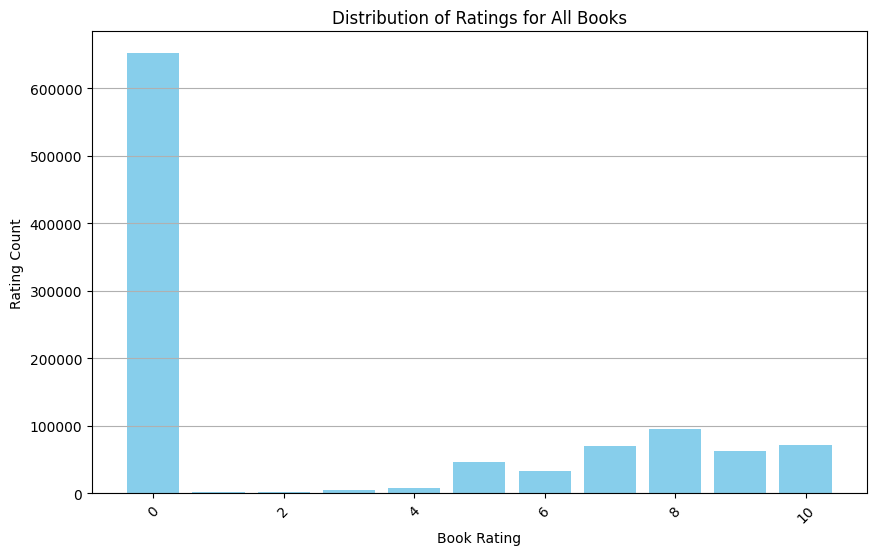

In [0]:
# Group by the book rating and count the occurrences of each rating
rating_distribution = ratings.groupBy("book_rating").agg(count("book_rating").alias("rating_count"))
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
rating_distribution_pd = rating_distribution.orderBy("book_rating").toPandas()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(rating_distribution_pd['book_rating'], rating_distribution_pd['rating_count'], color='skyblue')
plt.xlabel('Book Rating')
plt.ylabel('Rating Count')
plt.title('Distribution of Ratings for All Books')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Positive Skewing Nonzero responses
Pretty big positive skew. It makes sense that most people only read books they like, they probably only go to the effort of logging into a book rating website to log their ratings if they're invested in it. Also, maybe people dont finish bad books, and dont go to effort of rating

In [0]:
non_zero_ratings = ratings.filter(ratings.book_rating != 0)

### Most (Non-zero) Rated and Highest Rated Books

In [0]:
from pyspark.sql.functions import avg

avg_ratings = non_zero_ratings.groupBy("isbn").agg(avg("book_rating").alias("avg_rating"))
avg_ratings = avg_ratings.join(books.select("isbn", "book_title", "book_author"), on="isbn", how="left")
display(avg_ratings.orderBy(avg_ratings["avg_rating"].desc()).limit(100))

from pyspark.sql.functions import count

# Most rated books
most_rated_books = non_zero_ratings.groupBy("isbn").agg(count("book_rating").alias("num_ratings"))
most_rated_books = most_rated_books.join(books.select("isbn", "book_title", "book_author"), on="isbn", how="left")
display(most_rated_books.orderBy(most_rated_books["num_ratings"].desc()).limit(100))

# Highest rated books (with at least 50 ratings)
highest_rated_books = avg_ratings.join(most_rated_books.select("isbn", "num_ratings"), on="isbn", how="inner")
highest_rated_books = highest_rated_books.filter(highest_rated_books["num_ratings"] >= 50)
display(highest_rated_books.orderBy(highest_rated_books["avg_rating"].desc()).limit(100))

#display(most_rated_books.filter(most_rated_books.book_title.contains("Life of Pi")).orderBy(most_rated_books["count"].desc()))

isbn,avg_rating,book_title,book_author
0375719164,10.0,Like Life: Stories,Lorrie Moore
0905895622,10.0,Tom Adams' Agatha Christie cover story,Tom Adams
3491420091,10.0,Mein Esel Benjamin.,Lennart Osbeck
0452267218,10.0,Salem's Lot (The Stephen King collectors edition),Stephen King
0671824295,10.0,MEM ANOTHER DAY,Harold robbins
0439071631,10.0,El visitante (Animorphs),K. A. Applegate
033029623X,10.0,Jules and Jim,Henri Pierre Roche
0307740439,10.0,The Pagemaster (Golden Sound Story),Mary Dykstra
0749385103,10.0,Paddy Clarke Ha Ha Ha,Roddy Doyle
1850791988,10.0,Italian Cooking Tuscan,Elizabeth Cornish


isbn,num_ratings,book_title,book_author
0316666343,635,The Lovely Bones: A Novel,Alice Sebold
0971880107,526,Wild Animus,Rich Shapero
0385504209,450,The Da Vinci Code,Dan Brown
0312195516,353,The Red Tent (Bestselling Backlist),Anita Diamant
0679781587,302,null,null
0060928336,292,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
059035342X,285,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling
0142001740,283,The Secret Life of Bees,Sue Monk Kidd
0446672211,265,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts
044023722X,259,A Painted House,John Grisham


isbn,avg_rating,book_title,book_author,num_ratings
0345339738,9.41095890410959,"The Return of the King (The Lord of the Rings, Part 3)",J.R.R. TOLKIEN,73
0439139597,9.232,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,125
0064400557,9.166666666666666,Charlotte's Web (Trophy Newbery),E. B. White,60
0345339711,9.160493827160494,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,81
0439136369,9.11864406779661,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,118
0439136350,9.096,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,125
043935806X,9.015873015873016,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,189
0590353403,9.00952380952381,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,105
0439139600,8.94,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,100
0439064864,8.939130434782609,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,115


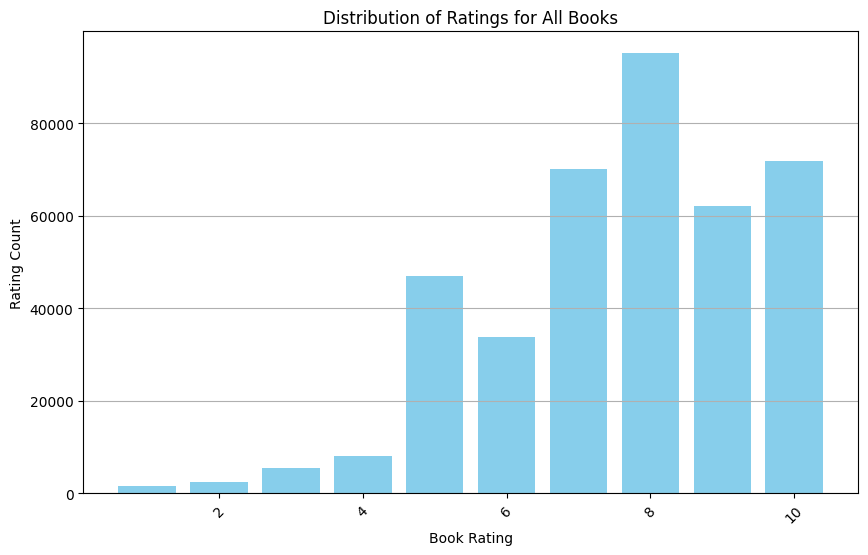

In [0]:
# Group by the book rating and count the occurrences of each rating
non_zero_rating_distribution = non_zero_ratings.groupBy("book_rating").agg(count("book_rating").alias("rating_count"))
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
non_zero_rating_distribution_pd = non_zero_rating_distribution.orderBy("book_rating").toPandas()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(non_zero_rating_distribution_pd['book_rating'], non_zero_rating_distribution_pd['rating_count'], color='skyblue')
plt.xlabel('Book Rating')
plt.ylabel('Rating Count')
plt.title('Distribution of Ratings for All Books')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### There are lots of users who only rated a single book

In [0]:
#ratings per user
ratings_per_user = non_zero_ratings.groupBy("user_id").agg(count("book_rating").alias("user_num_ratings"))
user_count_distribution = ratings_per_user.groupBy("user_num_ratings").agg(count("user_id").alias("user_count"))

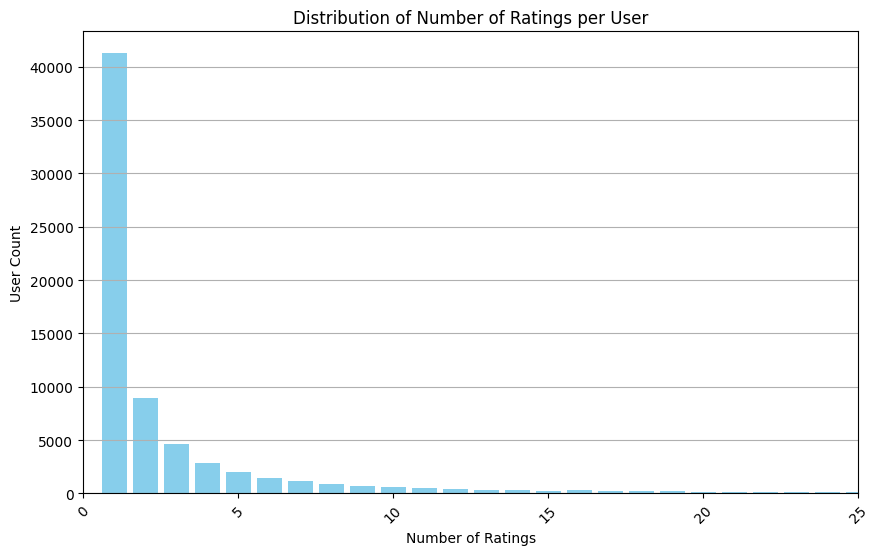

In [0]:
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
count_distribution_pd = user_count_distribution.orderBy("user_num_ratings").toPandas()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(count_distribution_pd['user_num_ratings'], count_distribution_pd['user_count'], color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('User Count')
plt.title('Distribution of Number of Ratings per User')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.xlim(0, 25)

# Display the plot
plt.show()



### There are lots of Books with just a single rating
The way this dataset is set up, is that each edition gets its own ISBN number, so ratings are attached to editions and not the book itself, which makes it much more difficult for less popular books, or books with more editions to have true aggregate ratings. If this was a Data Engineering course, i would spent alot more time fixing this issue, and making sure the book ratings are added together. Titles also seem to change between editions and between countries releases and if its part of a Anthology or Series? It seems difficult. For this project, i was content to just filter out books with low ratings.

In [0]:
#ratings per book
ratings_per_book = non_zero_ratings.groupBy("isbn").agg(count("book_rating").alias("book_num_ratings"))
book_count_distribution = ratings_per_book.groupBy("book_num_ratings").agg(count("isbn").alias("book_count"))

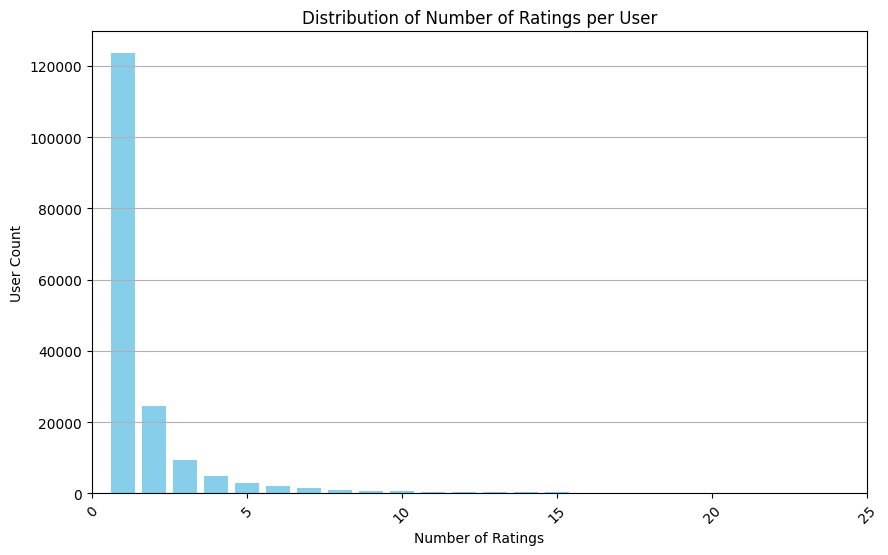

In [0]:
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
book_count_distribution_pd = book_count_distribution.orderBy("book_num_ratings").toPandas()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(book_count_distribution_pd['book_num_ratings'], book_count_distribution_pd['book_count'], color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('User Count')
plt.title('Distribution of Number of Ratings per User')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.xlim(0, 25)

# Display the plot
plt.show()


#Filtering out Books and Users
I filtered out users that had rated less than 4 books, and similarly books with less than 4 ratings.e 

In [0]:
# Filter books with at least n ratings
book_counts = non_zero_ratings.groupBy("isbn").agg(count("book_rating").alias("book_num_ratings"))
popular_books = book_counts.filter("book_num_ratings >= 4").select("isbn")

# Filter users with at least n ratings
user_counts = non_zero_ratings.groupBy("user_id").agg(count("book_rating").alias("user_num_ratings"))
active_users = user_counts.filter("user_num_ratings >= 4").select("user_id")



# Filter the original DataFrame
filtered_non_zero_ratings = non_zero_ratings.join(active_users, "user_id").join(popular_books, "isbn")


### Normalizing nonzero ratings, and user/book bias
Global mean mean centering around 0 and remove user and book bias. New Rating = Book rating - user_bias - book_bias - global mean.

In [0]:
#book rating - user_bias - book_bias - global mean 

# Compute global mean rating
global_mean = filtered_non_zero_ratings.agg(avg("book_rating").alias("global_mean")).collect()[0]["global_mean"]

# Compute user bias
user_bias = filtered_non_zero_ratings.groupBy("user_id").agg((avg("book_rating") - global_mean).alias("user_bias"))

# Compute book bias
book_bias = filtered_non_zero_ratings.groupBy("isbn").agg((avg("book_rating") - global_mean).alias("book_bias"))

# Join biases back to the original ratings
ratings_with_bias = filtered_non_zero_ratings.join(user_bias, "user_id", "left").join(book_bias, "isbn", "left")

# Remove user and book bias
non_zero_ratings_debiased = ratings_with_bias.withColumn(
    "debiased_rating",
    col("book_rating") - col("user_bias") - col("book_bias") - global_mean
)

display(non_zero_ratings_debiased.select("user_id", "isbn", "book_rating", "debiased_rating").limit(10))

user_id,isbn,book_rating,debiased_rating
195770,0679745327,7,2.5724810821450443
27193,0679449434,5,-0.40450304483908184
153662,0515090654,10,1.3634818892475487
194600,0671042556,8,0.3372175592601625
278390,0375409440,8,1.917719177383141
55548,1884822282,10,-1.1007993411353798
30487,0385473117,8,1.984883356487618
194287,0380898187,10,0.9275230989517667
137688,0877017883,10,0.5891435009038055
234597,0786869011,8,-1.9406141559501933


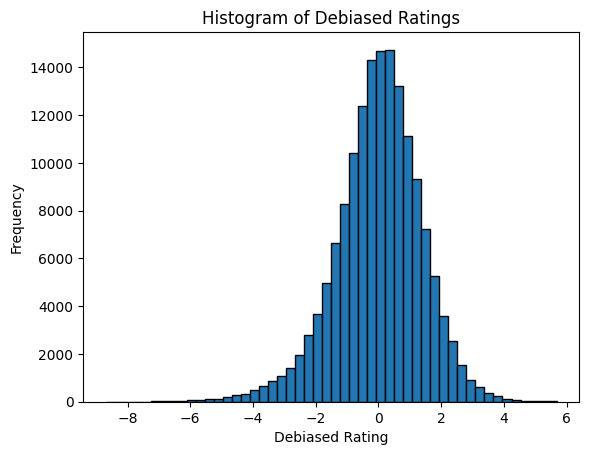

In [0]:
# Collect debiased ratings
debiased_ratings = non_zero_ratings_debiased.select("debiased_rating").toPandas()["debiased_rating"].tolist()

# Plot histogram
plt.hist(debiased_ratings, bins=50, edgecolor='black')
plt.title('Histogram of Debiased Ratings')
plt.xlabel('Debiased Rating')
plt.ylabel('Frequency')
plt.show()

### User-Item Collaborative Filtering
User-item collaborative filtering is a technique used in recommendation systems to predict a user's preferences for items based on the preferences of other users who have similar tastes. The system gathers data on user-item interactions, such as ratings, reviews, or purchase history. It calculates the similarity between users based on their interactions with items. For example, if two users consistently rate the same items similarly, they are considered similar. Based on the calculated similarities, the system identifies items that similar users have interacted with but the target user hasn't. These items are then recommended to the target user. 


In [0]:
from pyspark.sql.functions import col, avg, count, sum as spark_sum, sqrt, try_divide

# Self join to get user pairs who rated the same item
user_pairs = non_zero_ratings_debiased.alias("r1").join(
    non_zero_ratings_debiased.alias("r2"),
    (col("r1.isbn") == col("r2.isbn")) & (col("r1.user_id") < col("r2.user_id"))
).select(
    col("r1.user_id").alias("user1"),
    col("r2.user_id").alias("user2"),
    col("r1.debiased_rating").alias("rating1"),
    col("r2.debiased_rating").alias("rating2")
)

# Compute Pearson correlation similarity between user pairs
user_similarities = user_pairs.groupBy("user1", "user2").agg(
    spark_sum(col("rating1") * col("rating2")).alias("numerator"),
    spark_sum(col("rating1") * col("rating1")).alias("denom1"),
    spark_sum(col("rating2") * col("rating2")).alias("denom2"),
    count("*").alias("n_common")
).withColumn(
    "similarity",
    col("numerator") / (sqrt(col("denom1")) * sqrt(col("denom2")))
).filter(col("n_common") >= 2)  # filter for at least 2 co-rated items

# Function to get top-N similar users for a given user
def get_top_similar_users(user_id, top_n=5):
    sim_users = user_similarities.filter((col("user1") == user_id) | (col("user2") == user_id))
    sim_users = sim_users.withColumn(
        "similar_user",
        col("user2")
    ).where(
        col("user1") == user_id
    ).union(
        sim_users.withColumn(
            "similar_user",
            col("user1")
        ).where(
            col("user2") == user_id
        )
    ).select("similar_user", "similarity").orderBy(col("similarity").desc()).limit(top_n)
    return sim_users

# Function to recommend items for a user
def recommend_for_user(user_id, top_n=5):
    # Get top similar users
    top_sim_users = get_top_similar_users(user_id, top_n=top_n)
    # Get items rated by similar users but not by the target user
    user_items = non_zero_ratings_debiased.filter(col("user_id") == user_id).select("isbn").distinct()
    sim_user_ids = [row.similar_user for row in top_sim_users.filter(col("similarity") > 0).collect()]
    sim_users_ratings = non_zero_ratings_debiased.filter(col("user_id").isin(sim_user_ids))
    candidate_items = sim_users_ratings.join(user_items, on="isbn", how="left_anti")
    # Score by weighted sum of ratings
    sim_df = top_sim_users.withColumnRenamed("similar_user", "user_id")
    scored = candidate_items.join(sim_df, on="user_id").groupBy("isbn").agg(
        try_divide(spark_sum(col("similarity") * col("debiased_rating")), spark_sum(col("similarity"))).alias("score")
    ).orderBy(col("score").desc()).limit(top_n)
    return scored

### Top 10 Recommendations for a specific User:

In [0]:
# Top n recs for a user
user_id = 1
top_n = 10
user_recommendations = recommend_for_user(user_id, top_n)
display(user_recommendations)

display(non_zero_ratings_debiased.filter(col("user_id") == user_id))

isbn,score
0312967004,5.413671686827286
0394743121,4.747005020160618
0671041908,4.247005020160618
0099839407,4.100779286672758
1570719586,4.08033835349395
0684848961,3.9970050201606178
0307100146,3.9970050201606178
0399142282,3.8557006723345313
0451208501,3.8184335915891885
0786011858,3.7470050201606178


isbn,user_id,book_rating,user_bias,book_bias,debiased_rating
0553294385,1,9,0.1489474892835272,0.4254180775188203,0.6745819224811793
0140620109,1,7,0.1489474892835272,0.8489474892835265,-1.7489474892835268
0441008291,1,10,0.1489474892835272,-0.41771917738314013,2.517719177383139
0446603775,1,10,0.1489474892835272,-0.6260525107164732,2.726052510716473
0441003613,1,10,0.1489474892835272,0.9156141559501929,1.1843858440498067
055321313X,1,9,0.1489474892835272,1.165614155950193,-0.06561415595019326
0446601977,1,10,0.1489474892835272,0.08228082261685987,2.017719177383139
0451450523,1,8,0.1489474892835272,0.5822808226168608,-0.4822808226168611
0451526384,1,7,0.1489474892835272,0.04894748928352666,-0.948947489283527
0380004801,1,8,0.1489474892835272,0.49894748928352683,-0.3989474892835272


In [0]:
#joining on the title and image urls
recommended_items_with_books = user_recommendations.join(books, user_recommendations["isbn"] == books["isbn"], "left")
recommended_items_with_books = recommended_items_with_books.drop(books["isbn"])
recommended_items_with_books = recommended_items_with_books.orderBy(col("score").desc())
display(recommended_items_with_books)



isbn,score,book_title,book_author,year_of_publication,publisher,image_url_l
0312967004,5.413671686827286,Eleven Hours,Paullina Simons,1999,St. Martin's Press,http://images.amazon.com/images/P/0312967004.01.LZZZZZZZ.jpg
0394743121,4.747005020160618,Ulysses (Gabler Edition),James Joyce,1986,Vintage,http://images.amazon.com/images/P/0394743121.01.LZZZZZZZ.jpg
0671041908,4.247005020160618,The Coming Global Superstorm,Art Bell,1999,Atria,http://images.amazon.com/images/P/0671041908.01.LZZZZZZZ.jpg
0099839407,4.100779286672758,null,null,null,null,null
1570719586,4.08033835349395,God-Shaped Hole,Tiffanie DeBartolo,2002,Sourcebooks Landmark,http://images.amazon.com/images/P/1570719586.01.LZZZZZZZ.jpg
0307100146,3.9970050201606178,Walt Disney's 101 Dalmatians: Pongo to the Rescue (Golden Super Shape Book),Justine Korman,1994,Random House Childrens Books,http://images.amazon.com/images/P/0307100146.01.LZZZZZZZ.jpg
0684848961,3.9970050201606178,Chocolate For A Womans Heart : 77 Stories Of Love Kindness And Compassion To Nourish Your Soul And Sweeten Yo,Kay Allenbaugh,1998,Fireside,http://images.amazon.com/images/P/0684848961.01.LZZZZZZZ.jpg
0399142282,3.8557006723345313,Hornet's Nest,Patricia Daniels Cornwell,1997,Putnam Publishing Group,http://images.amazon.com/images/P/0399142282.01.LZZZZZZZ.jpg
0451208501,3.8184335915891885,Bubbles in Trouble (Bubbles Books),Sarah Strohmeyer,2003,Signet Book,http://images.amazon.com/images/P/0451208501.01.LZZZZZZZ.jpg
0786011858,3.7470050201606178,House of Secrets,Lowell Cauffiel,1998,Pinnacle Books,http://images.amazon.com/images/P/0786011858.01.LZZZZZZZ.jpg


### Top 10 Recommendations (Image Gallery)

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

# Add an index column for display purposes
recommended_items_with_books_with_id = recommended_items_with_books.withColumn("id", monotonically_increasing_id())

# Select only the columns needed for image display
images_df = recommended_items_with_books_with_id.select("id", "image_url_l", "book_title")

# Display images using Databricks HTML rendering
def display_images(df, url_col="image_url_l", title_col="book_title", n=10):
    rows = df.limit(n).collect()
    html = "<div style='display:flex;flex-wrap:wrap;max-width:800px;'>"
    for row in rows:
        url = row[url_col]
        title = row[title_col]
        html += f"<div style='margin:10px;text-align:center;'><img src='{url}' style='height:200px;'><br>{title}</div>"
    html += "</div>"
    displayHTML(html)

display_images(images_df)

Eleven Hours Ulysses (Gabler Edition) The Coming Global Superstorm None God-Shaped Hole Walt Disney's 101 Dalmatians: Pongo to the Rescue (Golden Super Shape Book) Chocolate For A Womans Heart : 77 Stories Of Love Kindness And Compassion To Nourish Your Soul And Sweeten Yo Hornet's Nest Bubbles in Trouble (Bubbles Books) House of Secrets

In [0]:
from pyspark.sql.functions import when

non_zero_isbns = [row['isbn'] for row in non_zero_ratings_debiased.select("isbn").distinct().collect()]
display(
    ratings.filter(col("user_id") == 7)
    .join(books, on="isbn", how="left")
    .withColumn("in_non_zero_ratings_debiased", when(col("isbn").isin(non_zero_isbns), "yes").otherwise("no"))
    .select("book_title", "book_rating", "book_author", "in_non_zero_ratings_debiased")
    .sort(col("book_rating").desc())
)



book_title,book_rating,book_author,in_non_zero_ratings_debiased
Ella Enchanted (Trophy Newbery),10,Gail Carson Levine,yes
War and Peace (Wordsworth Classics),10,Leo Tolstoy,yes
Le Petit Prince,9,Antoine de Saint-Exupéry,yes
"The Bad Beginning (A Series of Unfortunate Events, Book 1)",8,Lemony Snicket,yes
"Frankenstein Or, the Modern Prometheus",8,Mary Wollstonecraft Shelley,yes
The Hitchhiker's Guide to the Galaxy,7,Douglas Adams,yes
Animal Farm,5,George Orwell,yes
The Hobbit : The Enchanting Prelude to The Lord of the Rings,3,J.R.R. TOLKIEN,yes
Life of Pi,3,Yann Martel,yes
Moby-Dick,2,HERMAN MELVILLE,yes


### Diversity: 
I checked diversity on recommended Book's Authors. I was worried users who had read a popular series (for example all seven Harry Potter books are in the top 10 highest rated books with more than 50 ratings) for this dataset, would also have probably read and rated the rest of the series, and then users with similar tastes to them might end up with a top recommendations list of all of the same author which wouldn't be exciting. It's not a "true" diversity by genre or another metric, i was more just worried about suggesting too many from the same author.

### Novelty:
calculating the novelty of a set of recommended items (books), using their popularity among users in training data. Novelty is measured based on how uncommon or rarely interacted-with the recommended items are — less popular items are considered more novel. A higher novelty score means more niche or lesser-known books are being recommended. A lower novelty score means more popular books are in the recommendations. A normalized score near 1 means high novelty (rare items). Near 0 means low novelty (popular items)

In [0]:
from pyspark.sql.functions import count, lit, col, avg, when, log2


# Prepare item popularity from ratings
item_popularity = non_zero_ratings_debiased.groupBy("isbn").agg(count("*").alias("popularity"))
total_items = item_popularity.count()
total_users = non_zero_ratings_debiased.select("user_id").distinct().count()

# Add popularity rank (lower popularity = higher rank)
item_popularity = item_popularity.withColumn(
    "popularity_rank", (lit(total_items) - col("popularity") + 1)
)

# Placeholder for result rows
results = []

for user_id in range(1, 8):  # Users 1 to 7
    # Get recommendations
    recommended_items = recommend_for_user(user_id, top_n=10)  # Adjust top_n as needed
    
    # Join book metadata if needed (assuming `books` has 'isbn', 'book_author')
    recommended_items_with_books = recommended_items.join(books, on="isbn", how="left")

    # ---- Novelty ----
    rec_with_pop = recommended_items_with_books.join(item_popularity, on="isbn", how="left")

    # Handle null popularity
    rec_with_pop = rec_with_pop.withColumn(
        "popularity", when(col("popularity").isNull(), lit(1.0)).otherwise(col("popularity"))
    )
    
    rec_with_pop = rec_with_pop.withColumn(
        "novelty_inverse", -log2(col("popularity") / lit(total_users))
    )
    
    novelty = rec_with_pop.agg(avg("popularity_rank").cast("double")).first()[0]
    normalized_novelty = novelty / total_items if novelty else 0.0
    novelty_inverse_score = rec_with_pop.agg(avg("novelty_inverse").cast("double")).first()[0]

    # ---- Diversity ----
    authors_df = recommended_items_with_books.select("isbn", "book_author").distinct()
    authors_list = [row.book_author for row in authors_df.collect()]
    n = len(authors_list)
    
    if n <= 1:
        diversity = 0.0
    else:
        diversity = 1.0 if len(set(authors_list)) == n else 1.0 - (n - len(set(authors_list))) / (n * (n - 1) / 2)

    novelty = novelty if novelty is not None else 0.0
    novelty_inverse_score = novelty_inverse_score if novelty_inverse_score is not None else 0.0
    normalized_novelty = normalized_novelty if normalized_novelty is not None else 0.0
    diversity = diversity if diversity is not None else 0.0

    results.append((user_id, float(novelty), float(novelty_inverse_score), float(normalized_novelty), float(diversity)))

# Create and display final results
results_df = spark.createDataFrame(results, ["user_id", "novelty", "novelty_inverse_score", "normalized_novelty", "diversity"])
display(results_df)


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-6826040483465375>, line 8
      5 spark = SparkSession.builder.getOrCreate()
      7 # Prepare item popularity from ratings
----> 8 item_popularity = non_zero_ratings_debiased.groupBy("isbn").agg(count("*").alias("popularity"))
      9 total_items = item_popularity.count()
     10 total_users = non_zero_ratings_debiased.select("user_id").distinct().count()

NameError: name 'non_zero_ratings_debiased' is not defined

## Matrix Factorization (Weighted)

### User Book Matrix

## Filtering Dataset
This code filters the ratings dataset to include only users with at least 10 ratings and books with at least 20 ratings, ensuring sufficient activity. It then assigns a unique integer index (item_idx) to each remaining book (isbn) and renames the user_id column to user_idx for model input.

In [0]:
from pyspark.sql.functions import col

user_counts = ratings.filter(col("book_rating") > 0).groupBy("user_id").count()
active_users = user_counts.filter(col("count") >= 10).select("user_id")
filtered_ratings = ratings.join(active_users, on="user_id", how="inner")


book_counts = filtered_ratings.groupBy("isbn").count()
active_books = book_counts.filter(col("count") >= 20).select("isbn")
filtered_ratings = filtered_ratings.join(active_books, on="isbn", how="inner")


isbn_map = {row['isbn']: idx for idx, row in enumerate(filtered_ratings.select("isbn").distinct().collect())}
isbn_map_udf = F.udf(lambda isbn: isbn_map.get(isbn, -1), IntegerType())

filtered_ratings = filtered_ratings.withColumn("item_idx", isbn_map_udf("isbn"))

filtered_ratings = filtered_ratings.withColumnRenamed("user_id", "user_idx")


### Confidence Score for Explicit Weighting
This code sets up a confidence score for each user-item rating, where explicit ratings are scaled by 1 + alpha * rating and implicit interactions default to 1.0. It creates a new DataFrame C_df containing the user and item indices, original rating, and calculated confidence values for use in weighted matrix factorization.

In [0]:
# alpha controls confidence on explicit ratings
alpha = 40.0

# Confidence column: implicit = 1.0, explicit = 1 + alpha * rating
C_df = filtered_ratings.withColumn(
    "confidence",
    F.when(F.col("book_rating") > 0, 1 + alpha * F.col("book_rating")).otherwise(1.0)
).select("user_idx", "item_idx", "book_rating", "confidence")





### Init random latent factor vectors
Initializes random latent factor vectors (length = 10) for each user and item using NumPy, creating Pandas DataFrames for user_factors and item_factors. These are then converted into Spark DataFrames (user_factors_df and item_factors_df) to be used in matrix factorization.

In [0]:
import numpy as np
import pandas as pd

# Randomly initialize factors
np.random.seed(42)
rank = 10  # number of latent features

num_users = C_df.select("user_idx").distinct().count()
num_items = C_df.select("item_idx").distinct().count()

user_factors = pd.DataFrame({
    "user_idx": list(range(num_users)),
    "factors": [np.random.rand(rank).astype(np.float32) for _ in range(num_users)]
})

item_factors = pd.DataFrame({
    "item_idx": list(range(num_items)),
    "factors": [np.random.rand(rank).astype(np.float32) for _ in range(num_items)]
})

#user_factors_df = C_df.select("user_idx").distinct().withColumn("factors", F.expr(f"array_repeat(rand(), {rank})"))
#item_factors_df = C_df.select("item_idx").distinct().withColumn("factors", F.expr(f"array_repeat(rand(), {rank})"))

user_factors_df = spark.createDataFrame(user_factors)
item_factors_df = spark.createDataFrame(item_factors)

#display(user_factors_df.limit(20))

### ALS
Function updates a single user's latent factor vector by solving a regularized least squares problem using their interactions and corresponding item factors. It computes matrices A and b based on confidence-weighted outer products and ratings, then solves for the updated user vector and returns it as a DataFrame.

In [0]:
def update_user_factors(pdf: pd.DataFrame, item_vecs: pd.DataFrame) -> pd.DataFrame:
    item_vecs = item_vecs.set_index("item_idx")
    user = pdf['user_idx'].iloc[0]

    A = np.zeros((rank, rank), dtype=np.float32)
    b = np.zeros(rank, dtype=np.float32)

    for _, row in pdf.iterrows():
        i = row['item_idx']
        c = row['confidence']
        r_ui = row['book_rating']
        y_i = np.array(item_vecs.loc[i]['factors'])

        A += c * np.outer(y_i, y_i) + lambda_eye
        b += c * r_ui * y_i

    x_u = np.linalg.solve(A, b)
    return pd.DataFrame([[user, x_u.astype(np.float32)]], columns=["user_idx", "factors"])

In [0]:
def update_item_factors(pdf: pd.DataFrame, user_vecs: pd.DataFrame) -> pd.DataFrame:
    user_vecs = user_vecs.set_index("user_idx")
    item = pdf['item_idx'].iloc[0]

    A = np.zeros((rank, rank), dtype=np.float32)
    b = np.zeros(rank, dtype=np.float32)

    for _, row in pdf.iterrows():
        u = row['user_idx']
        c = row['confidence']
        r_ui = row['book_rating']
        x_u = np.array(user_vecs.loc[u]['factors'])

        A += c * np.outer(x_u, x_u) + lambda_eye
        b += c * r_ui * x_u

    y_i = np.linalg.solve(A, b)
    return pd.DataFrame([[item, y_i.astype(np.float32)]], columns=["item_idx", "factors"])


In [0]:
ratings_df = C_df  # Contains: user_idx, item_idx, book_rating, confidence

for iteration in range(10):
    print(f"ALS Iteration {iteration + 1}")

    # === Update user factors ===
    # Convert item factors to pandas for use in the function
    item_factors_pd = item_factors_df.toPandas()

    # Join ratings with item factors to update users
    user_join = ratings_df.join(item_factors_df, on="item_idx")

    user_factors_df = user_join.groupBy("user_idx").applyInPandas(
        lambda pdf: update_user_factors(pdf, item_factors_pd),
        schema=user_schema
    )

    # === Update item factors ===
    # Convert user factors to pandas for use in the function
    user_factors_pd = user_factors_df.toPandas()

    # Join ratings with user factors to update items
    item_join = ratings_df.join(user_factors_df, on="user_idx")

    item_factors_df = item_join.groupBy("item_idx").applyInPandas(
        lambda pdf: update_item_factors(pdf, user_factors_pd),
        schema=item_schema
    )


ALS Iteration 1
ALS Iteration 2
ALS Iteration 3
ALS Iteration 4
ALS Iteration 5
ALS Iteration 6
ALS Iteration 7
ALS Iteration 8
ALS Iteration 9
ALS Iteration 10


### Prediction
Reenames the user and item latent factor columns for clarity, then joins them with the ratings data to prepare for prediction. It defines a UDF to compute the dot product between user and item vectors and adds the resulting predicted rating as a new column called "prediction".

In [0]:


# Rename for clarity
user_factors_df_renamed = user_factors_df.withColumnRenamed("factors", "user_factors")
item_factors_df_renamed = item_factors_df.withColumnRenamed("factors", "item_factors")

pred_df = ratings_df \
    .join(user_factors_df_renamed, on="user_idx") \
    .join(item_factors_df_renamed, on="item_idx")

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

@udf(FloatType())
def dot_product(user_vec, item_vec):
    return float(np.dot(user_vec, item_vec))



pred_df = pred_df.withColumn("prediction", dot_product("user_factors", "item_factors"))
  

In [0]:
predictions = pred_df.select("user_idx", "item_idx", "prediction")



### Top 10 Books for each of my Coworkers
We'll compare these to the UBCF ones

In [0]:
from pyspark.sql.functions import col
from pyspark.sql import Row

# Define the list of target users
target_users = spark.createDataFrame([Row(user_idx=i) for i in range(1, 8)])

# Get all items
all_items = item_factors_df.select("item_idx").distinct()

# Generate candidate pairs: every item for each user (users 1–7)
candidate_pairs = target_users.crossJoin(all_items)


In [0]:
joined_df = candidate_pairs \
    .join(user_factors_df_renamed, on="user_idx") \
    .join(item_factors_df_renamed, on="item_idx")


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

@udf(FloatType())
def dot_product(user_vec, item_vec):
    return float(np.dot(user_vec, item_vec))

scored_df = joined_df.withColumn("prediction", dot_product("user_factors", "item_factors"))


In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("user_idx").orderBy(col("prediction").desc())

top_recommendations = scored_df.withColumn("rank", row_number().over(window_spec)) \
                               .filter(col("rank") <= 10) \
                               .select("user_idx", "item_idx", "prediction", "rank")


In [0]:
top_recommendations.orderBy("user_idx", "rank").show(100, truncate=False)


+--------+--------+----------+----+
|user_idx|item_idx|prediction|rank|
+--------+--------+----------+----+
|1       |1494    |16.966578 |1   |
|1       |543     |16.891861 |2   |
|1       |827     |16.821844 |3   |
|1       |1170    |16.626366 |4   |
|1       |1874    |16.316015 |5   |
|1       |3996    |16.196184 |6   |
|1       |1716    |15.926072 |7   |
|1       |1798    |15.738433 |8   |
|1       |1018    |15.6361   |9   |
|1       |52      |14.970243 |10  |
|2       |4017    |27.487793 |1   |
|2       |3266    |19.641777 |2   |
|2       |3623    |18.882627 |3   |
|2       |596     |18.728569 |4   |
|2       |3602    |18.400625 |5   |
|2       |2509    |17.730303 |6   |
|2       |417     |17.608725 |7   |
|2       |1750    |17.221497 |8   |
|2       |2340    |16.924603 |9   |
|2       |967     |16.844816 |10  |
|3       |4391    |19.8246   |1   |
|3       |1750    |18.084276 |2   |
|3       |1051    |17.29741  |3   |
|3       |2323    |15.5716095|4   |
|3       |2926    |14.889411

In [0]:
top_recommendations = top_recommendations.join(filtered_ratings.select("item_idx", "isbn"), on="item_idx", how="left")
top_recommendations = top_recommendations.join(books.select("isbn", "book_title"), on="isbn", how="left")

top_recommendations = top_recommendations.dropDuplicates(["user_idx", "item_idx"])

display(top_recommendations.orderBy("user_idx", "rank"))

isbn,item_idx,user_idx,prediction,rank,book_title
0446516325,1494,1,16.966578,1,Fat Tuesday
0373218958,543,1,16.891861,2,Less Of A Stranger (Silhouette Single Title)
3404148665,827,1,16.821844,3,Illuminati.
0307301451,1170,1,16.626366,4,Disney's the Lion King (Little Golden Book)
0399143696,1874,1,16.316015,5,Then Came Heaven
0440407079,3996,1,16.196184,6,Blubber (Yearling Books (Paperback))
0345384733,1716,1,15.926072,7,Red Square
0446608378,1798,1,15.738433,8,Thunderhead
0380808307,1018,1,15.6361,9,Just Imagine
0380975068,52,1,14.970243,10,The Lust Lizard of Melancholy Cove


### Top 10 Books (Image Gallery)

In [0]:
top_10_books = spark.table("gschneiderproject6.default.top_10_books")
top_10_books = top_10_books.join(books.select("isbn", "image_url_l"), on="isbn", how="left")
display(top_10_books)

isbn,item_idx,user_idx,prediction,rank,book_title,image_url_l
0380975068,52,1,14.97026825,10,The Lust Lizard of Melancholy Cove,http://images.amazon.com/images/P/0380975068.01.LZZZZZZZ.jpg
0312955006,76,5,16.13894272,8,The Concrete Blonde (A Harry Bosch Novel),http://images.amazon.com/images/P/0312955006.01.LZZZZZZZ.jpg
082177462X,246,4,35.7508049,3,Kentucky Sunrise,http://images.amazon.com/images/P/082177462X.01.LZZZZZZZ.jpg
0446600709,417,2,17.60940552,7,Assumed Identity,http://images.amazon.com/images/P/0446600709.01.LZZZZZZZ.jpg
0061091316,505,7,53.7549324,1,Lost Boys,http://images.amazon.com/images/P/0061091316.01.LZZZZZZZ.jpg
0679771476,537,4,32.22299957,8,The Law of Similars,http://images.amazon.com/images/P/0679771476.01.LZZZZZZZ.jpg
0373218958,543,1,16.89243698,2,Less Of A Stranger (Silhouette Single Title),http://images.amazon.com/images/P/0373218958.01.LZZZZZZZ.jpg
0590494503,584,5,16.30207634,6,"You Can't Scare Me! (Goosebumps, No 15)",http://images.amazon.com/images/P/0590494503.01.LZZZZZZZ.jpg
0671415085,583,4,31.47525978,10,IF THERE BE THORN,http://images.amazon.com/images/P/0671415085.01.LZZZZZZZ.jpg
0743436830,596,6,11.03203106,5,"River Road (Ross, Joann. Callahan Brothers Trilogy, 2.)",http://images.amazon.com/images/P/0743436830.01.LZZZZZZZ.jpg


In [0]:

images_df = top_10_books.filter("user_idx = 3")


# Display images using Databricks HTML rendering
def display_images(df, url_col="image_url_l", title_col="book_title", n=10):
    rows = df.limit(n).collect()
    html = "<div style='display:flex;flex-wrap:wrap;max-width:750;'>"
    for row in rows:
        url = row[url_col]
        title = row[title_col]
        html += f"<div style='margin:10px;text-align:center;'><img src='{url}' style='height:200px;'><br>{title}</div>"
    html += "</div>"
    displayHTML(html)

display_images(images_df)

The Hearse You Came in On (Hitchcock Sewell Mysteries (Paperback)) On a Wild Night (Cynster Novels) Excavation Years Feeling Sorry for Celia : A Novel My Sergei : A Love Story Waiting For Nick (Silhouette Special Edition) Billy Straight: A Novel Dead Poets Society The Keys to the Street: A Novel of Suspense

### RMSE - Not so well suited
With weighted matrix factorization we're not predicting explicit ratings directly. Instead, we're modeling implicit preferences. We're optimizing for ranking, not rating accuracy. RMSE: 5.1866 means our model is predicting on average 5.2 rating points away from the actual book ratings (on a 1–10 scale), but this error may not fully reflect how good the model is at ranking the most relevant items.

In [0]:
from pyspark.sql.functions import col, pow

rating_and_preds = pred_df.withColumn("squared_error", pow(col("book_rating") - col("prediction"), 2))

from pyspark.sql.functions import sqrt, avg

rmse = rating_and_preds.select(sqrt(avg("squared_error")).alias("rmse")).collect()[0]["rmse"]
print(f"RMSE: {rmse:.4f}")



RMSE: 5.1866


## Novelty 
We approximate by calculating the average inverse popularity of the recommended items for a user. This gives you a per-user average novelty score for the top-10 recommendations. A higher novelty means more rare or surprising recommendations (less commonly interacted items). 

In [0]:
#Compute item popularity (number of unique users who rated each item)
from pyspark.sql.functions import countDistinct

item_popularity = ratings_df.groupBy("item_idx") \
    .agg(countDistinct("user_idx").alias("popularity"))


In [0]:
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

#filter predictions for users 1–7 and get top K
K = 10
target_users = list(range(1, 8))

filtered_preds = predictions.filter(col("user_idx").isin(target_users))

window_spec = Window.partitionBy("user_idx").orderBy(col("prediction").desc())

top_k_preds = filtered_preds.withColumn("rank", row_number().over(window_spec)) \
                            .filter(col("rank") <= K)


In [0]:
#Join top-K predictions with item popularity
top_k_with_pop = top_k_preds.join(item_popularity, on="item_idx", how="left")


In [0]:
#Define novelty as -log2(popularity / total_users)
total_users = ratings_df.select("user_idx").distinct().count()

from pyspark.sql.functions import log2, lit

top_k_with_pop = top_k_with_pop.withColumn(
    "novelty_score",
    -log2(col("popularity") / lit(total_users))
)


In [0]:
#Compute average novelty per user
user_novelty = top_k_with_pop.groupBy("user_idx") \
    .agg({"novelty_score": "avg"}) \
    .withColumnRenamed("avg(novelty_score)", "avg_novelty@10")




In [0]:
total_users

6253

### Score	Item Popularity	Interpretation for Novelty = -log₂(popularity / total_users) for 6253 Total Users
4:	~391 users	~6.25%	Popular items <br>
6:	~98 users	~1.56%	Moderately novel — not mainstream <br>
8:	~24 users	~0.38%  Quite novel — niche or uncommon items

The novelty score of ~6 for most of my coworkers indicates that the recommendations are somewhat novel, leaning toward the less mainstream side, but not extremely obscure. This is usually a healthy balance, showing enough relevance without being too obvious or too obscure.

In [0]:
display(user_novelty.orderBy("user_idx"))

user_idx,avg_novelty@10
1,7.477481764226884
2,6.696452094505251
3,8.219652945148805
4,6.624529512271225
5,7.103106079589213
6,6.733215371353813
7,6.465660676410858


## Summary

We didn’t know as many pre-2004 books as we thought 
It was hard to know if the ratings would’ve been a hit in 2004 or if a recommendation just wasn’t good <br>
Model 1 UBCF got an edge by showing more popular books 
Novelty is good but it’s important to have at least 1 mainstream book listed to give your list some legitimacy
UBCF struggles when your user profile is too unique <br>
But, Users can also be insulted when they feel like they got “default” options
I was too worried about Harry Potter (or a single author) clogging up everyone’s list just because they were in the popular list


## Improvements

I could’ve tried giving the implicit ratings a higher weighted confidence 
Taking the time to ship books to other users and log it is a bigger implicit sign than the current “click rate” on websites <br>
I could have added Genre data to enrich the dataset
Could’ve captured which weren't captured by collaborative signals alone <br>
ISBN’s being unique to each printed book edition creates difficulties in aggregating
I wish I had time to fix all the issues with the book editions, the data would be more accurate and the recommendations would be too<br>
Deweighting books that had just released that year
Flavor of the month/year

